# Kalman as Bayesian Update with Gaussians 

## Two Prerequisites


### P1: Two Matrix  Identities

#### Id 1: Nameless
$$
\begin{align}
(A+B)^{-1} 
&= (BB^{-1}A + BA^{-1}A)^{-1}  = A^{-1}(A^{-1} + B^{-1})^{-1} B^{-1} 
\end{align}
$$
 

#### Id 2: [Woodbury Matrix Id](https://en.wikipedia.org/wiki/Woodbury_matrix_identity):
$$
(X^{-1} + Y^{-1})^{-1} = X - 
X  (X + Y)^{-1} X
$$

This follows form the full idenity, after the substuition of $(A,B,C,D)\hookrightarrow (X^{-1},\mathbb{1},Y^{-1},\mathbb{1})$:
$$
(A + BCD)^{-1} = A^{-1} - 
A^{-1} B (C^{-1} + D A^{-1} B)^{-1} D A^{-1} 
$$


### P2: Posterior = Likelihood $\times$ Prior, with the above identities

We have both:
1. $\mathcal{N}(\mu_0, \Sigma_0)$ 
2. $\mathcal{N}(\mu_1, \Sigma_1)$ 


The productor of the two: $\mathcal{N}(\mu_2, \Sigma_2)$, with
* $\Sigma_2 \leftarrow \left\{ \Sigma_2^{-1} = \Sigma_0^{-1} + \Sigma_1^{-1} \right\} $
* $\mu_2 \leftarrow \left\{ \Sigma_2^{-1}\mu_2 = \Sigma_0^{-1} \mu_0 + \Sigma_1^{-1} \mu_1 \right\} $

Using above Woodbury identy, it can be rewritten with $K = \Sigma_0 (\Sigma_0 +\Sigma_1)^{-1}$, as
- $\Sigma_2 = (\Sigma_0^{-1} + \Sigma_1^{-1})^{-1} 
\xrightarrow{\text{Woodbury}}
\Sigma_0  - K \Sigma_0$

- $\mu_2 = \Sigma_2 (\Sigma_0^{-1} \mu_0 + \Sigma_1^{-1} \mu_1) \xrightarrow{\text{Nameless}}
\mu_0 + K(\mu_1-\mu_0)$




## Our System Specification 
(aka all the assumptions, for better or worse)

Model Specification:
On top of $X \sim \mathcal{N}(x,P)$ and $\xi \sim \mathcal{N}(0, Q)$, we also have the evolution equation, leading to: 
$$
\begin{align}
X(t+1) &= A(t) X(t) +  \xi(t) \\
P(t+1) &= A(t) P(t) A(t)^T + Q(t) 
\end{align}
$$
Observation Specification: 
$$z(t+1)|_{X(t+1)} \sim \mathcal{N}(H(t) x(t+1), R(t+1)) $$



## Kalman Update, as Bayesian Update of Gaussians

From model specification, we have $(x_0,P_0)  \xrightarrow{\text{Model}} (x_1,P_1)$:
* $x_1 \equiv \mathbb{E}(X_1) = F x_0$
* $P_1 = A P_0 A^T + Q$

From observed divation in $z$, we have to adjust $(x_1,P_1) \xrightarrow{\text{Obs}} (x_2,P_2)$
- $z$-space Prior: $\mathcal{N}(H x_1, H P_1 H^T)$
- $z$-space Likelihood: $\mathcal{N}(z,R)$

- $z$-space Posterior: $\mathcal{N}(H x_2, H P_2 H^T)$
    * $K = H P_1 H^T (H P_1 H^T + R)^{-1}$
    * $H x_2 = H x_1 + K(z - H x_1 )$
    * $H P_2 H^T = H P_1 H^T - K H P_1 H^T$

- Refining $K = H K_G$, we have,
    - $K_G = P_1 H^T (H P_1 H^T + R)^{-1}$
    - $x_2 = x_1 + K_G (z - H x_1 )$
    - $P_2 = P_1  - K_G H P_1 $


#  EWM as Kalman with random walk + noise 

Under random walk + noise model, with observation that has zero expected distortion ($h \equiv \mathbb{1}$):
$$
\begin{align}
\mathcal{N}(x_0,p_0)  
&\xrightarrow{\text{latent:} \xi\sim \mathcal{N}(0,Q) }
&\mathcal{N}(x_1=x_0,p_1=p_0+Q) \\
&\xrightarrow{\text{obs:}\mathcal{N}(Z,R) }
&\mathcal{N}(x_2=x_1,p_2 = \frac{p_1 R}{p_1+R}) 
\end{align}
$$

We know that for EWM, the role of $\alpha$ is to incrementally mixing the new input with the old memory, which is the same as our $K$: Therefore, we can use the recursive limit (aka steady state) to map one into another:
$$
\begin{align}
K &\xrightarrow{\text{steady state}}  &K_{\infty}&=\sqrt{t (1 + \frac{t}{4})}  - \frac{t}{2} \, \Big|_{t = \frac{Q}{R}} \\
& &\alpha &\equiv 1 - e^{-\frac{\ln 2}{h}} \\
\end{align}
$$


Identify the two ($\alpha=K_{\infty}$) leads to the relation between 
1. $t\equiv \frac{Q}{R}$, the precision of the observation apparatus (how $t$rust-worthy is the apparatus);
2. $h$, the half life of the exponential decay.

$$
\begin{align}
h &= \frac{
    \ln 2
}{
\ln \bigg(1 + \sqrt{t (1 + \frac{t}{4})}  + \frac{t}{2} \bigg)
} \\
t &= \frac{
    (x-1)^2
}{
x
}\Bigg|_{x = e^{-\frac{\ln 2}{h} }}  \xrightarrow{h>1} \frac{1}{2 h^2}  \\
\end{align}
$$

# Python Exp
## Preamble

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(15,4)})

import seaborn as sns
sns.set(style='whitegrid')

import bambi as bmb, pandas as pd, numpy as np, arviz as az, pymc as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf


# $K_{\infty}$ must be scale correctly
$K \xrightarrow{\text{steady state}}  K_{\infty}=\sqrt{t (1 + \frac{t}{4})}  - \frac{t}{2} \, \Big|_{t = \frac{Q}{R}} $

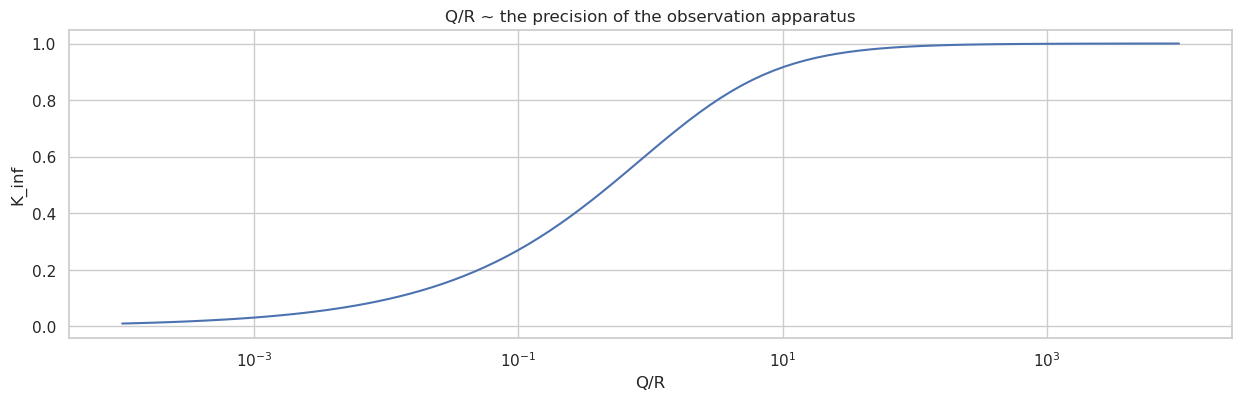

In [53]:
t= 10**np.linspace(-4,4,100)
y= pd.Series(np.sqrt(t*(1+t/4)) - t/2, index=t)
y.plot(xlabel='Q/R',ylabel='K_inf', title='Q/R ~ the precision of the observation apparatus'); 
plt.xscale('log');

# Halflife as a function of Q/R

Notice we get a clean mapping with hf>1 

In [3]:
def hf2t(hf):
    x = np.exp(-np.log(2)/hf)    
    return (x-1)**2/x

def t2hf(t):
    return np.log(2)/np.log(1 + t/2 + np.sqrt(t+t*t/4))

t = 10**np.linspace(-4,4,60)
hf = t2hf(t)
df_hf = pd.DataFrame(dict(t=t,hf=hf),index=t)
df_hf.query('hf>=1').sort_values('t').tail()

,t,hf
0.131415,0.131415,1.922442
0.179571,0.179571,1.647798
0.245375,0.245375,1.413363
0.335292,0.335292,1.213396
0.458160,0.458160,1.042989


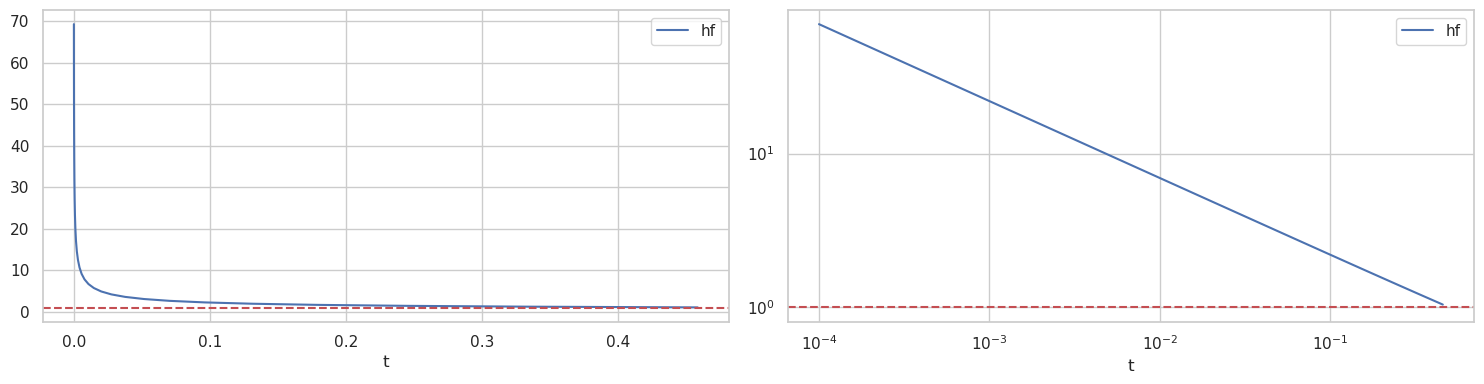

In [4]:
dftmp = df_hf.query('hf>1')
dftmp.set_index('t').plot(ax=plt.subplot(121)); plt.axhline(1,color='r',ls='--')
dftmp.set_index('t').plot(ax=plt.subplot(122)); plt.axhline(1,color='r',ls='--')
plt.xscale('log'); plt.yscale('log')
plt.tight_layout()

In [5]:
smf.ols('np.log(t)~np.log(hf)',data=dftmp).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.7169,0.002,-303.816,0.000,-0.722,-0.712
np.log(hf),-2.0052,0.001,-2104.820,0.000,-2.007,-2.003


In [6]:

from scipy.optimize import curve_fit
popt, pcov = curve_fit(
    f=lambda x,a,b:a*x**b ,  
    xdata=dftmp.hf, 
    ydata=dftmp.t)
popt

array([ 0.49818552, -2.03710436])

In [7]:
v = np.sqrt(np.diag(pcov))
outer_v = np.outer(v, v)
pcov / outer_v

array([[ 1.        , -0.67192502],
       [-0.67192502,  1.        ]])

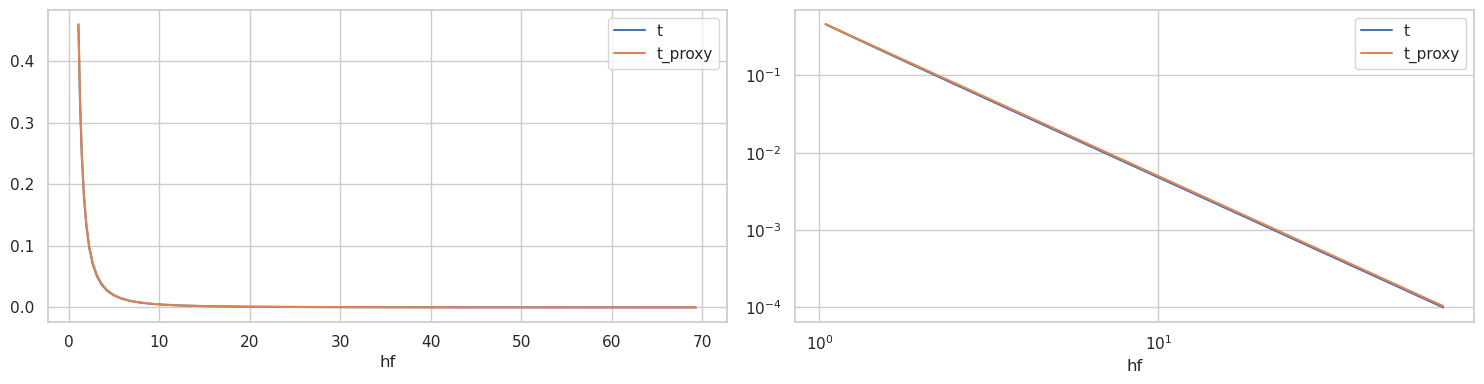

In [8]:
dftmp2 = dftmp.assign(t_proxy=lambda df: 0.5/df.hf**2)
dftmp2.set_index('hf').plot(ax=plt.subplot(121));
dftmp2.set_index('hf').plot(ax=plt.subplot(122));
plt.xscale('log'); plt.yscale('log')
plt.tight_layout()

# How fast is the asymptopic, $K_{\infty}$, reached?

In [31]:
def myUtil(N,P_init,Q,R ):
    import itertools
    def update_1st(p0, _):
        p1 = p0+ Q
        p2 = p1*R/(p1+R)
        return p2
    
    tmp = np.empty(N)
    tmp[0] = P_init
    tmp = np.array(list(itertools.accumulate(tmp,update_1st)))
    return (tmp+Q)/(tmp+Q+R)
    


In [58]:
t2hf(10)

0.2797329727066677

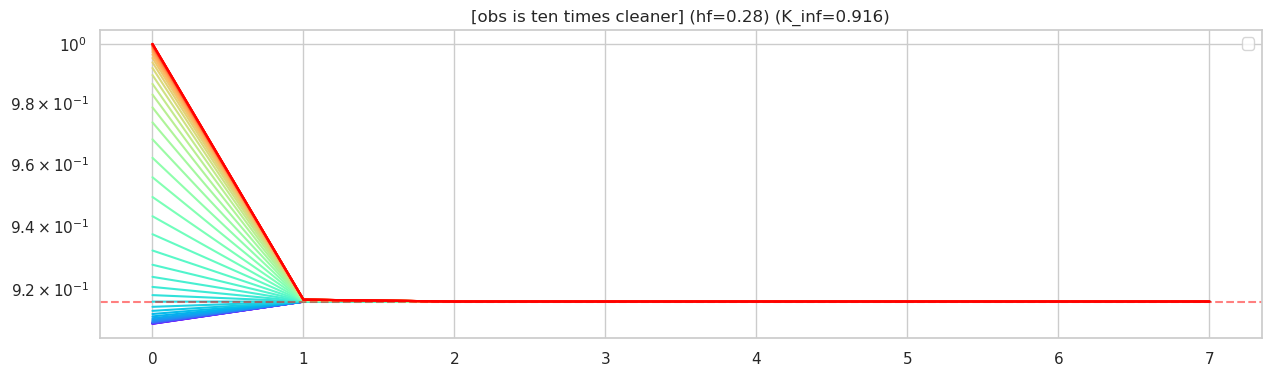

In [48]:
N,Q,R = 10,1,1/10

df_evol = pd.DataFrame({
    initial: myUtil(N=N,P_init=initial,Q=Q,R=R) 
    for initial in 10**np.linspace(-3,3,50)
},index=np.r_[:N])

df_evol.loc[:7].plot(
    cmap='rainbow',
    title=f'[obs is ten times cleaner] (hf={t2hf(Q/R):.2f}) (K_inf={df_evol.tail().stack().mean():.3f})'
); plt.legend('');
plt.axhline(klimit(Q/R),color='red',ls='--',alpha=0.5)
plt.yscale('log');

In [57]:
t2hf(0.1)

2.200992986498909

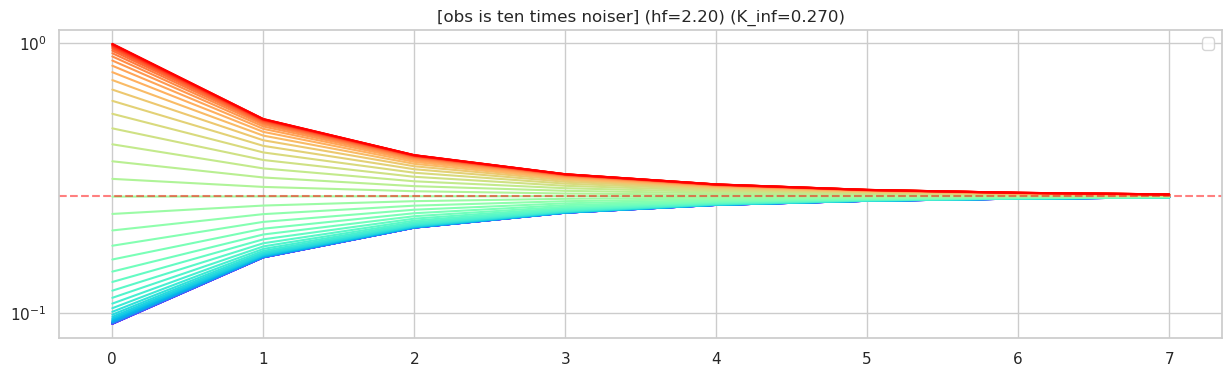

In [49]:
N,Q,R = 10,1,10

klimit = lambda t: (np.sqrt(t + t*t/4) - t/2) #t=Q/R

df_evol = pd.DataFrame({
    initial: myUtil(N=N,P_init=initial,Q=Q,R=R) 
    for initial in 10**np.linspace(-3,3,50)
},index=np.r_[:N])

df_evol.loc[:7].plot(
    cmap='rainbow',
    title=f'[obs is ten times noiser] (hf={t2hf(Q/R):.2f}) (K_inf={df_evol.tail().stack().mean():.3f})'
); plt.legend('');
plt.axhline(klimit(Q/R),color='red',ls='--',alpha=0.5); 
plt.yscale('log');

In [50]:
hf2t(20)

0.0012012527662230521

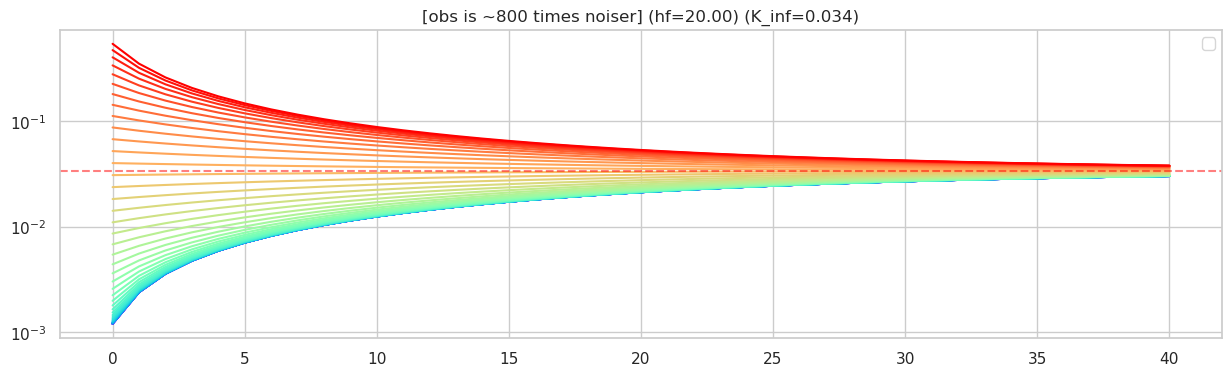

In [59]:
N,Q,R = 100,1,1/hf2t(20)

klimit = lambda t: (np.sqrt(t + t*t/4) - t/2) #t=Q/R

df_evol = pd.DataFrame({
    initial: myUtil(N=N,P_init=initial,Q=Q,R=R) 
    for initial in 10**np.linspace(-3,3,50)
},index=np.r_[:N])

df_evol.loc[:40].plot(
    cmap='rainbow',
    title=f'[obs is ~800 times noiser] (hf={t2hf(Q/R):.2f}) (K_inf={df_evol.tail().stack().mean():.3f})'
); plt.legend('');
plt.axhline(klimit(Q/R),color='red',ls='--',alpha=0.5)
plt.yscale('log');

In [83]:
t2hf(0.5) #  hf=1bin ~  50% truth-worth

1.0

In [80]:
t2hf(0.05) #  hf=3bin ~  5% truth-worth

3.10628371950539

In [84]:
t2hf(0.02) # hf=5 bins ~  2% truth-worth

4.905369354851815

In [85]:
t2hf(0.01) #  hf=7bin ~  1% truth-worth

6.934357875729564